# Data preprocessing

## emotion label + path to file

In [1]:
import pandas as pd
import numpy as np
import os

np.random.seed(646)

pathToData="../data/tess/"
imgsPath="../imgs/tess_hp_opt/"
modelsPath="../models/tess_hp_opt/"

def load_data(path):
    emotion, file_path = [], []
    
    # iterate over audio files extracting emotion label, file path and speaker info
    for root, _, files in os.walk(path):
        if len(files): # extract info only if files are found
            for filename in files:
                if filename.split('.')[1] == 'wav':
                    emotion.append(filename.split("_")[2].split(".")[0])
                    file_path.append(os.path.join(root, filename))
                
    # prepare dataframe
    audio_df = pd.DataFrame(emotion)
    audio_df = audio_df.replace({"ps": "surprised"})
    
    # concatenate file paths to emotion data frame
    audio_df = pd.concat([pd.DataFrame(file_path), audio_df], axis=1)
    audio_df.columns = ['path', 'emotion']
    
    return audio_df

df = load_data(pathToData)
df

,path,emotion
0,../data/tess/oaf/OAF_pike_sad.wav,sad
1,../data/tess/oaf/OAF_bought_disgust.wav,disgust
2,../data/tess/oaf/OAF_gin_sad.wav,sad
3,../data/tess/oaf/OAF_learn_angry.wav,angry
4,../data/tess/oaf/OAF_moon_neutral.wav,neutral
...,...,...
2795,../data/tess/yaf/YAF_cause_fear.wav,fear
2796,../data/tess/yaf/YAF_hate_ps.wav,surprised
2797,../data/tess/yaf/YAF_gun_happy.wav,happy
2798,../data/tess/yaf/YAF_chair_disgust.wav,disgust


# Plots

## class distribution

['sad' 'disgust' 'angry' 'neutral' 'fear' 'happy' 'surprised']


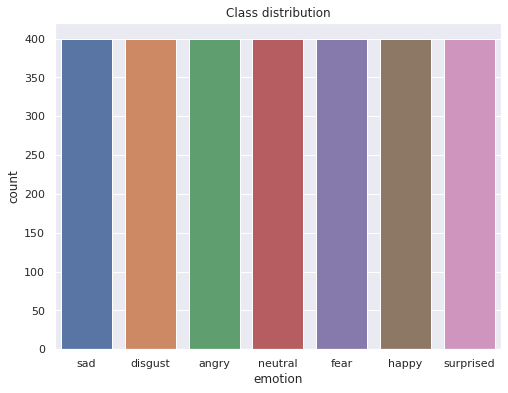

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# class imbalance plot
print(df['emotion'].unique())
sns.set_theme(style='darkgrid')
plt.figure(figsize=(8,6))
sns.countplot(x = 'emotion', data = df)
plt.title('Class distribution')
plt.savefig(imgsPath + 'class_distribution.png')
plt.show()

## waveform

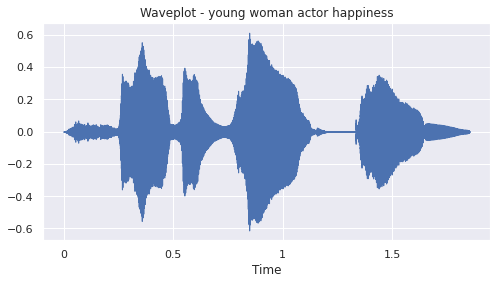

In [3]:
import librosa.display

# waveplot
wavf, sr = librosa.load('../data/tess/yaf/YAF_gun_happy.wav')

plt.figure(figsize = (8, 4))
librosa.display.waveshow(wavf, sr = sr)
plt.title('Waveplot - young woman actor happiness')
plt.savefig(imgsPath + 'waveplot_yaf_happiness.png')
plt.show()

## log-mel spectrogram

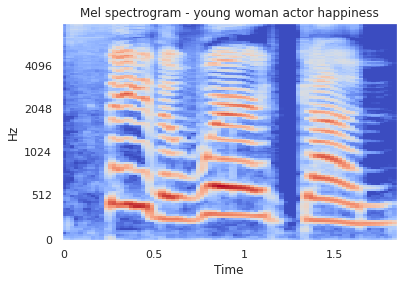

In [4]:
# log-mel spectrogram
spectrogram = librosa.feature.melspectrogram(y=wavf, sr=sr, n_mels=128, fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel spectrogram - young woman actor happiness')
plt.savefig(imgsPath + 'mel_spec_yaf_happiness.png')
plt.show()

# Feature extraction

- [mfcc extraction info](https://www.researchgate.net/profile/Teddy-Gunawan/publication/353296706_Speech_Emotion_Recognition_Using_Feature_Fusion_of_TEO_and_MFCC_on_Multilingual_Databases/links/613ef96f4e1df2710631ca0a/Speech-Emotion-Recognition-Using-Feature-Fusion-of-TEO-and-MFCC-on-Multilingual-Databases.pdf)
- [librosa docs](https://librosa.org/doc/latest/index.html)

In [5]:
import librosa

# log-mel spectrogram into mfcc

logMelSpecVal = []

def parse_audio_file(pathToFile, _duration, sampleRate):
    # load file
    wavf, sample_rate = librosa.load(pathToFile, res_type="kaiser_fast", duration=_duration, sr=sampleRate)
    
    # get mfcc features (coefficients = 13, filters = 32)
    mfcc = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=wavf, sr=sample_rate, n_mfcc = 13), axis=0)
    
    return mfcc

mfccVal = []

for fpath in df['path']:
    mfcc = parse_audio_file(fpath, 2, 44100)
    mfccVal.append(mfcc)
    
# merge emotions with features
df = pd.concat([df, pd.DataFrame(mfccVal)], axis=1)
    
# drop unnecessary column
df.drop(columns='path', inplace=True)

# fill na's
df = df.fillna(0)
df.head()

,emotion,0,1,2,3,4,5,6,7,8,...,163,164,165,166,167,168,169,170,171,172
0,sad,-44.866684,-42.563484,-42.934090,-42.198429,-38.585060,-37.314648,-39.344276,-39.559017,-38.614834,...,-41.979794,-38.103256,-35.165031,-30.712734,-25.250000,-21.929203,-19.830929,-19.868361,-22.233919,-21.251535
1,disgust,-41.202820,-38.517208,-37.521523,-35.928848,-36.701500,-37.414253,-36.393902,-33.882385,-32.767769,...,-20.967327,-22.963118,-22.885572,-22.221870,-23.507053,-24.068279,-25.479784,-24.551914,-20.904539,-16.470636
2,sad,-44.523106,-41.317688,-38.223133,-37.148476,-35.793209,-36.431770,-35.850277,-36.279404,-36.554703,...,-37.707291,-39.314594,-38.339470,-38.279835,-38.296024,-39.444401,-39.700020,-40.861137,-39.896214,-38.872395
3,angry,-41.129044,-41.145790,-40.203060,-40.004387,-39.338234,-38.796188,-36.842579,-37.031277,-36.232571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,neutral,-43.564331,-43.538578,-43.997803,-43.378044,-42.618168,-40.774433,-39.563217,-39.384590,-41.079617,...,-26.839230,-26.929281,-27.145792,-26.891811,-26.995079,-26.535362,-26.693199,-27.490786,-23.562895,-18.484276


# Data split

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def data_split(df):
    # divide data into labels and features
    X = df.iloc[:, :].drop(columns=['emotion'])
    y = df['emotion']
    
    # stratified train, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0, stratify=y)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_split(df)

print(X_train.head())
print(y_train.head())

            0          1          2          3          4          5    \
1957 -36.305271 -36.789738 -36.425220 -34.747608 -35.367222 -36.745964   
1105 -40.173527 -41.522141 -42.365028 -39.217091 -35.474632 -35.014355   
254  -43.793388 -43.241306 -43.019321 -41.574070 -40.106453 -35.029846   
2592 -32.160595 -29.258410 -23.278524 -22.255568 -26.362617 -29.601513   
1179 -31.665293 -35.141491 -42.677780 -44.319191 -46.104473 -45.569675   

            6          7          8          9    ...        163        164  \
1957 -36.117542 -36.514889 -36.810520 -36.554073  ... -36.101200 -39.634762   
1105 -34.125809 -33.744308 -32.054882 -32.173038  ...   0.000000   0.000000   
254  -33.976143 -34.539223 -33.108162 -34.407253  ... -46.415386 -39.463905   
2592 -29.792355 -33.346142 -32.624657 -30.397259  ... -27.827576 -29.221291   
1179 -42.089725 -39.481453 -39.381378 -37.650951  ... -26.674839 -26.402981   

            165        166        167        168        169        170  \
1957  

# Data preparation and normalization

In [8]:
from keras.utils import to_categorical
lb = LabelEncoder()
print(lb.fit_transform(y_train))
print(to_categorical(lb.fit_transform(y_train)))

2022-05-27 12:58:41.108663: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


[6 2 5 ... 3 6 6]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [9]:
from keras.utils import to_categorical

def data_preprocessing(X_train, X_test, y_train, y_test):

    # normalization (z-score, values between -1 and 1)
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std

    # turn data into arrays for keras
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(y_train.shape)
    print(y_test.shape)

    # label one hot encoding
    lb = LabelEncoder()
    y_train = lb.fit_transform(y_train)
    y_test = lb.fit_transform(y_test)

    print(y_test[0:3])

    print(lb.classes_)
    
    return X_train, X_test, y_train, y_test, lb

X_train, X_test, y_train, y_test, lb = data_preprocessing(X_train, X_test, y_train, y_test)

(2240,)
(560,)
[3 3 4]
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprised']


# SVM classification

In [45]:
from sklearn import svm

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

# Results

In [46]:
# predictions
predictions = clf.predict(X_test)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# actual labels
actual = y_test
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# combine both
finaldf = actual.join(predictions)
finaldf[1:10]

,Actual Values,Predicted Values
1,happy,happy
2,neutral,neutral
3,surprised,surprised
4,happy,happy
5,sad,sad
6,sad,neutral
7,fear,fear
8,surprised,surprised
9,surprised,surprised


## confusion matrix

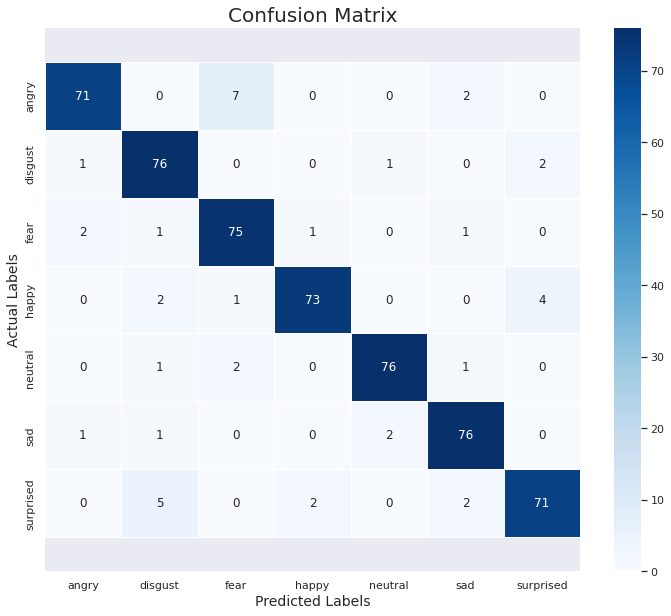

In [47]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix, actual vs predicted
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_], columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig(imgsPath + 'Initial_Model_Confusion_Matrix.png')
plt.show()

In [48]:
print(classification_report(actual, predictions, target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']))

              precision    recall  f1-score   support

       angry       0.95      0.89      0.92        80
     disgust       0.88      0.95      0.92        80
        fear       0.88      0.94      0.91        80
       happy       0.96      0.91      0.94        80
     neutral       0.96      0.95      0.96        80
         sad       0.93      0.95      0.94        80
   surprised       0.92      0.89      0.90        80

    accuracy                           0.93       560
   macro avg       0.93      0.93      0.93       560
weighted avg       0.93      0.93      0.93       560



# GMM classification

In [56]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=7)
gmm.fit(X_test)

GaussianMixture(n_components=7)

In [57]:
# predictions
predictions = gmm.predict(X_test)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# actual labels
actual = y_test
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# combine both
finaldf = actual.join(predictions)
finaldf[1:10]

,Actual Values,Predicted Values
1,happy,disgust
2,neutral,neutral
3,surprised,disgust
4,happy,disgust
5,sad,sad
6,sad,sad
7,fear,fear
8,surprised,disgust
9,surprised,disgust


## confusion matrix

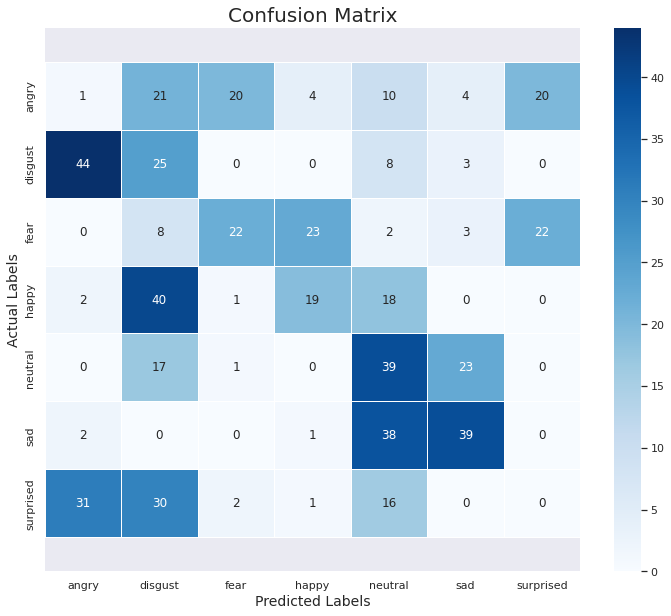

In [58]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix, actual vs predicted
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_], columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig(imgsPath + 'Initial_Model_Confusion_Matrix.png')
plt.show()

In [59]:
print(classification_report(actual, predictions, target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']))

              precision    recall  f1-score   support

       angry       0.01      0.01      0.01        80
     disgust       0.18      0.31      0.23        80
        fear       0.48      0.28      0.35        80
       happy       0.40      0.24      0.30        80
     neutral       0.30      0.49      0.37        80
         sad       0.54      0.49      0.51        80
   surprised       0.00      0.00      0.00        80

    accuracy                           0.26       560
   macro avg       0.27      0.26      0.25       560
weighted avg       0.27      0.26      0.25       560

